# 0. 사용할 패키지 Import

In [36]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import folium
import requests
import json
from bs4 import BeautifulSoup
from seoulMap import SeoulMap

# 1. 임대 상가 공실 변화 및 현황 분석

## 1-1. 지하상가 임대정보 데이터 불러오기 (2024년)
정보 출처 : 공공데이터포털 - 서울교통공사_지하상가임대정보 (https://www.data.go.kr/data/15071329/fileData.do)

* 모든 지하철역의 상가가 지하상가로 분류되는 것이 아니기 때문에 일부 역의 데이터는 없을 수 있다.

### 1-1-1. 데이터 리스트 가져오기

In [37]:
data_path = '../data/서울교통공사_지하상가_임대정보'
csv_list = [os.path.join(data_path, csv) for csv in os.listdir(data_path) if csv.endswith('csv') and csv.startswith('서울교통공사_지하상가_임대정보')]
print(csv_list)

['../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240131.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240229.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240331.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240430.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240531.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240630.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240731.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240831.csv', '../data/서울교통공사_지하상가_임대정보\\서울교통공사_지하상가_임대정보_20240930.csv']


### 1-1-2. 샘플 데이터를 통해 컬럼 확인

In [38]:
sample_df = pd.read_csv(csv_list[0], encoding='cp949')
print(sample_df.info())
print(sample_df.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   연번        1547 non-null   int64  
 1   상가유형      1547 non-null   object 
 2   호선        1547 non-null   object 
 3   역명        1547 non-null   object 
 4   상가번호      1547 non-null   object 
 5   면적(제곱미터)  1488 non-null   float64
 6   영업업종      1360 non-null   object 
 7   계약시작일자    1360 non-null   object 
 8   계약종료일자    1360 non-null   object 
 9   월임대료      1229 non-null   float64
 10  사업진행단계    187 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 133.1+ KB
None
    연번    상가유형   호선        역명     상가번호  면적(제곱미터)  영업업종      계약시작일자  \
0    1  개별(일반)  1호선    서울(1)역  150-107     33.00   사무실  2019-06-20   
1    2    네트워크  1호선    서울(1)역  150-109     12.00  패션잡화  2023-01-16   
2    3  개별(일반)  1호선    시청(1)역  151-101     29.73  패션잡화  2022-08-02   
3    4  개별(일반)  1호선    시청(1)역  151-10

## 1-2. 공실 데이터 현황

### 1-2-1. 공실 데이터 취합

In [39]:
empty_cnt_list = []
empty_pct_list = []

for csv in csv_list:
    df = pd.read_csv(csv, encoding='cp949')
    empty_space_df = df[df['상가유형'] == '공실'][['호선', '역명', '상가번호']].reset_index(drop=True)
    
    empty_cnt_list.append(len(empty_space_df))
    
    empty_pct = round(100 * len(empty_space_df)/ len(df), 2)
    empty_pct_list.append(empty_pct)

empty_dict = {'공실수':empty_cnt_list, '공실률':empty_pct_list}
empty_df = pd.DataFrame(empty_dict)
empty_df.index = [csv.split('_')[-1].split('.')[0] for csv in csv_list]
print(empty_df.head())

          공실수   공실률
20240131  108  6.98
20240229  118  7.60
20240331  124  7.99
20240430  131  8.48
20240531  142  9.24


### 1-2-2. 공실 데이터 시각화

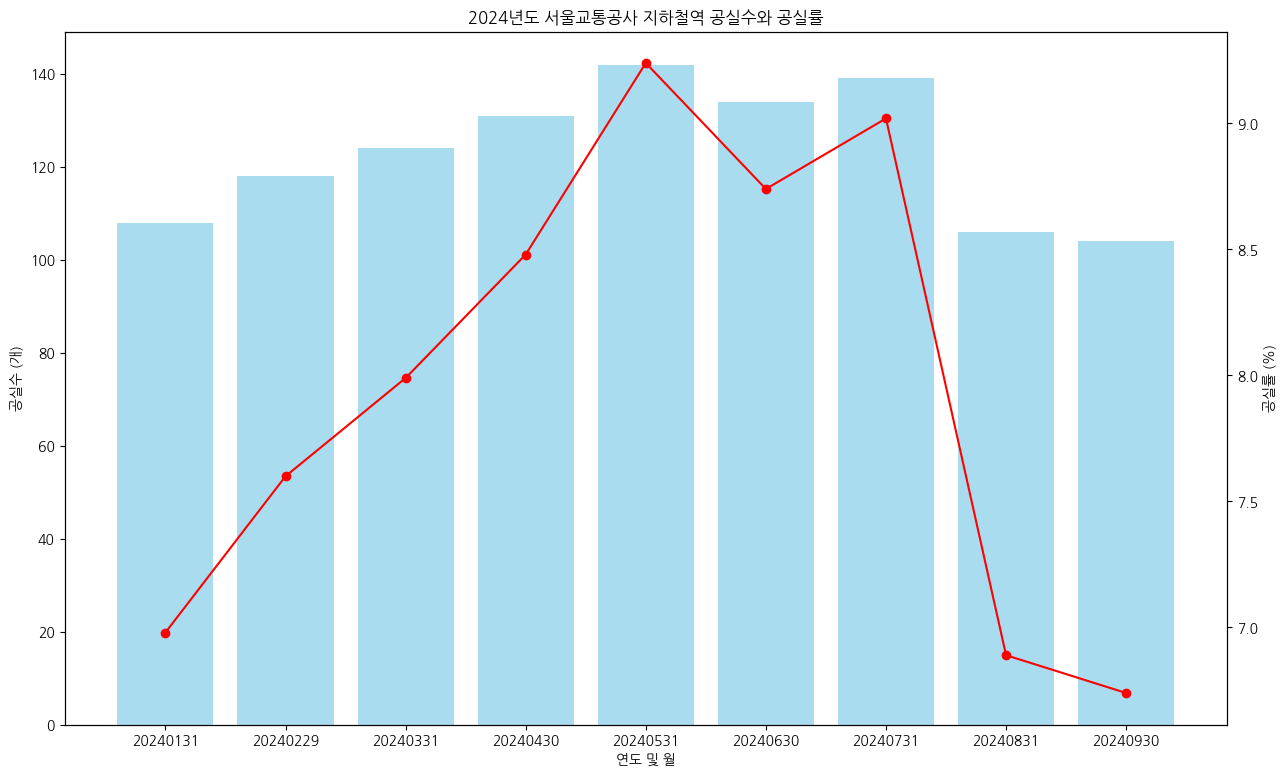

In [40]:
fig, ax1 = plt.subplots(figsize=(15, 9))

x = empty_df.index

ax1.bar(x, empty_df['공실수'], color='skyblue', label='공실수', alpha=0.7)
ax1.set_xlabel('연도 및 월')
ax1.set_ylabel('공실수 (개)')

ax2 = ax1.twinx()
ax2.plot(x, empty_df['공실률'], color='red', marker='o', label='col2')
ax2.set_ylabel('공실률 (%)')

plt.title('2024년도 서울교통공사 지하철역 공실수와 공실률')
plt.show()

## 1-3. 최신 공실 데이터 확인

### 1-3-1. 2024년 09월 기준 지하철 상가 임대 정보 데이터 정제

In [41]:
last_df = pd.read_csv(csv_list[-1], encoding='cp949')
re_last_df = last_df.copy()
re_last_df['역명'] = re_last_df['역명'].apply(lambda x: x[:-1])
re_last_df['역명'] = re_last_df['역명'].apply(lambda x:  x[:x.find('(')] + x[x.find('(')+3:] if '(' in x else x)
re_last_df['역명'] = re_last_df['역명'].apply(lambda x: '총신대입구/이수' if x in ('총신대입구', '이수') else x)

re_last_df = re_last_df[['호선', '역명', '상가유형', '면적(제곱미터)', '계약시작일자', '계약종료일자']]
print(re_last_df.head())

    호선  역명    상가유형  면적(제곱미터)      계약시작일자      계약종료일자
0  1호선  서울    네트워크     12.00  2023-01-16  2028-05-16
1  1호선  시청  개별(일반)     29.73  2022-08-02  2027-08-02
2  1호선  시청  개별(일반)     57.60  2020-02-01  2025-01-31
3  1호선  시청  개별(일반)     25.00  2020-12-31  2026-01-30
4  1호선  시청    네트워크     25.00  2021-06-03  2026-08-02


### 1-3-2. 위경도 데이터 불러오기

In [42]:
data_path = '../data/geoData/'
location_csv = os.path.join(data_path, '지하철역_위경도.csv')

location_df = pd.read_csv(location_csv, index_col='연번').reset_index(drop=True)
print(location_df.info())
print(location_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   호선            276 non-null    int64  
 1   고유역번호(외부역코드)  276 non-null    int64  
 2   역명            276 non-null    object 
 3   위도            276 non-null    float64
 4   경도            276 non-null    float64
 5   작성일자          276 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 13.1+ KB
None
   호선  고유역번호(외부역코드)    역명         위도          경도        작성일자
0   1           150    서울  37.553150  126.972533  1974-02-28
1   1           151    시청  37.563590  126.975407  1974-08-15
2   1           152    종각  37.570203  126.983116  1974-08-15
3   1           153  종로3가  37.570429  126.992095  1974-08-15
4   1           154  종로5가  37.570971  127.001900  1974-03-31


### 1-3-3. 위경도 데이터 정제하기

In [43]:
re_location_df = location_df.copy()
re_location_df['호선'] = re_location_df['호선'].apply(lambda x: f'{x}호선')
re_location_df['역명'] = re_location_df['역명'].apply(lambda x: '총신대입구/이수' if x in ('총신대입구', '이수') else x)
re_location_df = re_location_df[['호선', '역명', '위도', '경도']]
print(re_location_df.head(10))

    호선    역명         위도          경도
0  1호선    서울  37.553150  126.972533
1  1호선    시청  37.563590  126.975407
2  1호선    종각  37.570203  126.983116
3  1호선  종로3가  37.570429  126.992095
4  1호선  종로5가  37.570971  127.001900
5  1호선   동대문  37.571790  127.011383
6  1호선   동묘앞  37.573265  127.016459
7  1호선   신설동  37.576117  127.024710
8  1호선   제기동  37.578116  127.034902
9  1호선   청량리  37.580148  127.045063


## 1-4. 데이터 병합 및 시각화

### 1-4-1 데이터 병합 및 확인

In [44]:
df = pd.merge(left=re_last_df, right=re_location_df, how='left', on=['호선', '역명'])
df['공실(개)'] = df.groupby(['호선', '역명'])['상가유형'].transform(lambda x: (x == '공실').astype(int).sum())
empty_final_df = df[['호선', '역명', '위도', '경도', '공실(개)']].drop_duplicates().reset_index(drop=True)

print(empty_final_df.info())
print(empty_final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   호선      239 non-null    object 
 1   역명      239 non-null    object 
 2   위도      239 non-null    float64
 3   경도      239 non-null    float64
 4   공실(개)   239 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 9.5+ KB
None
    호선    역명         위도          경도  공실(개)
0  1호선    서울  37.553150  126.972533      0
1  1호선    시청  37.563590  126.975407      0
2  1호선    종각  37.570203  126.983116      4
3  1호선  종로3가  37.570429  126.992095      1
4  1호선  종로5가  37.570971  127.001900      0


In [45]:
print(empty_final_df.sort_values('공실(개)', ascending=False).head(10))

      호선      역명         위도          경도  공실(개)
53   3호선      홍제  37.588851  126.944092     13
197  7호선  어린이대공원  37.547962  127.074650      8
2    1호선      종각  37.570203  126.983116      4
200  7호선      청담  37.519097  127.051851      4
182  7호선     수락산  37.677804  127.055314      4
131  5호선      강동  37.535810  127.132490      4
95   4호선      사당  37.476563  126.981746      3
161  6호선      공덕  37.543592  126.951664      3
162  6호선   효창공원앞  37.539279  126.961348      3
65   3호선      교대  37.493060  127.013796      2


### 1-4-2 공실 정보 데이터 시각화

In [46]:
station_shop_map = SeoulMap()

total_shop_layer = station_shop_map.make_layer('지하임대상가 위치 정보')
check_empty_layer = station_shop_map.make_layer('공실 보유 여부')

for idx in empty_final_df.index:
    lat = empty_final_df['위도'][idx]
    lon = empty_final_df['경도'][idx]
    station_name = empty_final_df['역명'][idx]
    station_line = empty_final_df['호선'][idx]
    empty_cnt = empty_final_df['공실(개)'][idx]
    
    # 임대 상가 위치 정보 레이어
    total_shop_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color='blue', icon='map-marker'),
            tooltip=f"{station_name}역 ({station_line})",
        )
    )
    
    # 공실 보유 여부 레이어
    if empty_cnt:
        pin_color = 'red'
        icon_shape = 'exclamation-sign'
    else:
        pin_color = 'green'
        icon_shape = 'ok-sign'
        
    check_empty_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color=pin_color, icon=icon_shape),
            tooltip=f"{station_name}역 ({station_line}) : {empty_cnt}개",
        )
    )
    

station_shop_map.add_layer(total_shop_layer)
station_shop_map.add_layer(check_empty_layer)
station_shop_map.show()

### 1-4-3. 공실 있는 데이터만 다시 확인

In [47]:
empty_station_map = SeoulMap()
empty_filt_df = empty_final_df[empty_final_df['공실(개)'] != 0].reset_index(drop=True)

only_empty_layer = empty_station_map.make_layer('공실 개수에 따른 구분')

for idx in empty_filt_df.index:
    lat = empty_filt_df['위도'][idx]
    lon = empty_filt_df['경도'][idx]
    station_name = empty_filt_df['역명'][idx]
    station_line = empty_filt_df['호선'][idx]
    empty_cnt = empty_filt_df['공실(개)'][idx]
    
    # 공실 개수에 따른 구분 레이어
    if empty_cnt > 5:
        pin_color = 'red'
    else:
        pin_color = 'orange'
        
    only_empty_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color=pin_color, icon='exclamation-sign'),
            tooltip=f"{station_name}역 ({station_line}) : {empty_cnt}개",
        )
    )

empty_station_map.add_layer(only_empty_layer)

# 2. 또타 스토리지 현황

## 2-1. 현재 설치된 역 리스트
정보출처 : 서울교통공사 (http://www.seoulmetro.co.kr/kr/page.do?menuIdx=843)

* 5호선 - 신정역, 답십리역, 군자역

* 6호선 - 월드컵경기장역, 광흥창역, 창신역, 안암역, 봉화산역

* 7호선 - 중계역(2), 태릉입구역(2), 상봉역, 반포역, 이수역(2), 신풍역, 마들역, 하계역, 어린이대공원역, 논현역, 남성역

* 8호선 - 가락시장역(2)

괄호가 있는 역은 복수의 또타 스토리지가 설치된 역

### 2-1-1. 역명 리스트로 만들기 (수기)

In [48]:
manual_list = [
    '신정역', '답십리역', '군자역', '월드컵경기장역', '광흥창역',
    '창신역', '안암역', '봉화산역', '중계역', '태릉입구역',
    '상봉역', '반포역', '이수역', '신풍역', '마들역',
    '하계역', '어린이대공원역', '논현역', '남성역', '가락시장역'
]

### 2-1-2. 역명 리스트로 만들기 (크롤링)

In [49]:
def get_exist_stations(url, headers):
    '''
    또타 스토리지 조성 현황을 크롤링하기 위한 함수
    
    Prammeters:
    argument1 (str): 또타 스토리지 조성 현황 페이지 URL
    argument2 (dict): 헤더값 (User-Agent)
    
    Returns:
    list: 기존 또타 스토리지 역리스트 (가나다순)
    '''

    res = requests.get(url, headers=headers)
    station_list = []
    station_names = []

    if res.status_code == 200:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser')
        station_list = soup.find_all('td', class_='td-bor')
        station_names = set([re.sub('[^가-힣]', '', txt.text) for txt in station_list])

    return sorted(station_names)

In [50]:
print(get_exist_stations.__doc__)


    또타 스토리지 조성 현황을 크롤링하기 위한 함수

    Prammeters:
    argument1 (str): 또타 스토리지 조성 현황 페이지 URL
    argument2 (dict): 헤더값 (User-Agent)

    Returns:
    list: 기존 또타 스토리지 역리스트 (가나다순)
    


In [51]:
url = 'http://www.seoulmetro.co.kr/kr/page.do?menuIdx=843'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'
}
station_list = get_exist_stations(url, headers)
print(station_list)

['가락시장역', '광흥창역', '군자역', '남성역', '논현역', '답십리역', '마들역', '반포역', '봉화산역', '상봉역', '신정역', '신풍역', '안암역', '어린이대공원역', '월드컵경기장역', '이수역', '중계역', '창신역', '태릉입구역', '하계역']


### 2-1-3. 수기와 크롤링 정보 일치 여부 확인

In [52]:
print(set(manual_list) == set(station_list))

True


## 2-2. 현재 설치된 장소 시각화

### 2-2-1. 지하철 위경도 데이터 불러오기 (1-3-2 중복)

In [53]:
data_path = '../data/geoData/'
location_csv = os.path.join(data_path, '지하철역_위경도.csv')
# location_df

location_df = pd.read_csv(location_csv, index_col='연번').reset_index(drop=True)
# location_df.to_csv('지하철_위경도.csv', index=False)
print(location_df.head())

   호선  고유역번호(외부역코드)    역명         위도          경도        작성일자
0   1           150    서울  37.553150  126.972533  1974-02-28
1   1           151    시청  37.563590  126.975407  1974-08-15
2   1           152    종각  37.570203  126.983116  1974-08-15
3   1           153  종로3가  37.570429  126.992095  1974-08-15
4   1           154  종로5가  37.570971  127.001900  1974-03-31


### 2-2-2. 지하철 위경도 데이터 정제하기

필요한 컬럼만 남기고, 복수 호선의 역은 작은 숫자의 호선 데이터만 유지

ex) 동대문역사문화공원역: 2호선/4호선/5호선 환승역 -> 2호선에 해당하는 데이터만 유지)

In [54]:
re_location_df =location_df[['호선', '역명', '위도', '경도']]

print(re_location_df.head())

   호선    역명         위도          경도
0   1    서울  37.553150  126.972533
1   1    시청  37.563590  126.975407
2   1    종각  37.570203  126.983116
3   1  종로3가  37.570429  126.992095
4   1  종로5가  37.570971  127.001900


#### 설치/미설치 역 분류하기

In [55]:
# 기존 역명에 '역' 이라는 마지막 글자를 포함하고 있으므로 제거하기
re_station_list = [station[:-1] for station in station_list]
# print(re_station_list)

# 설치여부 컬럼 추가
filt_location_df = re_location_df.copy()
filt_location_df['설치여부'] = re_location_df['역명'].apply(lambda x: True if x in re_station_list else False)
print(filt_location_df.head())

   호선    역명         위도          경도   설치여부
0   1    서울  37.553150  126.972533  False
1   1    시청  37.563590  126.975407  False
2   1    종각  37.570203  126.983116  False
3   1  종로3가  37.570429  126.992095  False
4   1  종로5가  37.570971  127.001900  False


#### 데이터 확인 및 조정

In [56]:
# 설치 역 리스트와 갯수 비교 -> False
print(len(filt_location_df[filt_location_df['설치여부']]) == len(re_station_list))

# 개수 차이가 나는 역 찾기 -> 이수
find_station = set(re_station_list) - set(filt_location_df[filt_location_df['설치여부']]['역명'])
print(find_station)

# # 임시 확인 데이터 저장
# filt_location_df.to_csv('station_information.csv', index=False)

# 위경도 데이터에는 이수역이 총신대입구역으로만 표기되어있으므로 역명 변경하고 설치 여부 다시 확인
storage_final_df = filt_location_df.copy()
storage_final_df['역명'] = filt_location_df['역명'].apply(lambda x: '총신대입구/이수' if x == '총신대입구' else x)
re_station_list[re_station_list.index('이수')] = '총신대입구/이수'
storage_final_df['설치여부'] = storage_final_df['역명'].apply(lambda x: True if x in re_station_list else False)
storage_final_df['호선'] = storage_final_df['호선'].apply(lambda x: f'{x}호선')

# 데이터 다시 확인하기
print(len(storage_final_df[storage_final_df['설치여부']]) ==  len(re_station_list))
print(set(re_station_list) - set(storage_final_df[storage_final_df['설치여부']]['역명']))

False
{'이수'}
False
set()


### 2-2-3. 지도 시각화 하기

#### 지하철역 위치 및 또타스토리지 설치여부 레이어 생성

In [57]:
station_map = SeoulMap()
seoul_map = SeoulMap()

station_display_layer = station_map.make_layer('지하철역 위치 정보')
storage_display_layer = station_map.make_layer('또타스토리지 설치 여부')

with open('../data/geoData/서울특별시_경계_2017.geojson', encoding='utf-8') as f:
    seoul_geodata = json.load(f)

seoul_layer = seoul_map.make_layer('서울시 경계', seoul_geodata)
storage_only_layer = seoul_map.make_layer('또타스토리지 설치 역사')

for idx in storage_final_df.index:
    lat = storage_final_df['위도'][idx]
    lon = storage_final_df['경도'][idx]
    station_name = storage_final_df['역명'][idx]
    station_line = storage_final_df['호선'][idx]
    storage_flag = storage_final_df['설치여부'][idx]
    
    station_display_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color='blue', icon='map-marker'),
            tooltip=f"{station_name}역 ({station_line})",
        )
    )
    
    if storage_flag:
        pin_color = 'green'
        icon_shape = 'ok-sign'
        storage_only_layer.add_child(
            folium.Marker(
                location=[lat, lon],
                popup=f"<b>설명:</b> {station_name}역 ({station_line})",
                icon=folium.Icon(color=pin_color, icon=icon_shape),
                tooltip=f"{station_name}역 ({station_line})",
            )
        )
    else:
        pin_color = 'blue'
        icon_shape = 'minus-sign'
        
    storage_display_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color=pin_color, icon=icon_shape),
            tooltip=f"{station_name}역 ({station_line})",
        )
    )
    
station_map.add_layer(station_display_layer)
station_map.add_layer(storage_display_layer)

seoul_map.add_layer(seoul_layer)
seoul_map.add_layer(storage_only_layer)
station_map.show()

#### 공실 데이터에 또타스토리지 설치 여부 확인 및 레이어 생성

In [58]:
empty_check_df = pd.merge(left=empty_filt_df, right=storage_final_df, how='left', on=['호선', '역명'], suffixes=('', '_drop'))
empty_check_df = empty_check_df.drop(columns=[col for col in empty_check_df.columns if col.endswith('_drop')])

print(empty_check_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   호선      56 non-null     object 
 1   역명      56 non-null     object 
 2   위도      56 non-null     float64
 3   경도      56 non-null     float64
 4   공실(개)   56 non-null     int64  
 5   설치여부    56 non-null     bool   
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.4+ KB
None


In [59]:
empty_storage_layer = empty_station_map.make_layer('스토리지 설치 여부')

for idx in empty_check_df.index:
    lat = empty_check_df['위도'][idx]
    lon = empty_check_df['경도'][idx]
    station_name = empty_check_df['역명'][idx]
    station_line = empty_check_df['호선'][idx]
    empty_cnt = empty_check_df['공실(개)'][idx]
    storage_flag = empty_check_df['설치여부'][idx]
    
    # 공실 개수에 따른 구분 레이어
    if empty_cnt > 5:
        pin_color = 'red'
    else:
        pin_color = 'orange'
    
    if storage_flag:
        icon_shape = 'ok-sign'
    else:
        icon_shape = 'minus-sign'
    
        
    empty_storage_layer.add_child(
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>설명:</b> {station_name}역 ({station_line})",
            icon=folium.Icon(color=pin_color, icon=icon_shape),
            tooltip=f"{station_name}역 ({station_line}) : {empty_cnt}개",
        )
    )

empty_station_map.add_layer(empty_storage_layer)
empty_station_map.show()

# 3. 1인 가구 데이터 분석

## 3-1. 1인 가구 수 및 1인 가구 비중 분석

### 3-1-1. 데이터 리스트 가져오기

In [60]:
population_data_path = '../data/세대원수별_세대수'
population_csv_list = [os.path.join(population_data_path, csv) for csv in os.listdir(population_data_path)]
print(population_csv_list)

['../data/세대원수별_세대수\\세대원수별_세대수_202109.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202110.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202111.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202112.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202201.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202202.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202203.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202204.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202205.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202206.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202207.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202208.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202209.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202210.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202211.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202212.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202301.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202302.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202303.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202304.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202305.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202306.csv', '../data/세대원수별_세대수\\세대원수별_세대수_202307.csv', '../data/세

### 3-1-2. 샘플 데이터를 통해 컬럼 확인

In [61]:
sample_df = pd.read_csv(population_csv_list[0])
print(sample_df.info())
print(sample_df.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   동별(1)        452 non-null    object
 1   동별(2)        452 non-null    object
 2   2021. 09     452 non-null    object
 3   2021. 09.1   452 non-null    object
 4   2021. 09.2   452 non-null    object
 5   2021. 09.3   452 non-null    object
 6   2021. 09.4   452 non-null    object
 7   2021. 09.5   452 non-null    object
 8   2021. 09.6   452 non-null    object
 9   2021. 09.7   452 non-null    object
 10  2021. 09.8   452 non-null    object
 11  2021. 09.9   452 non-null    object
 12  2021. 09.10  452 non-null    object
dtypes: object(13)
memory usage: 46.0+ KB
None
    동별(1)        동별(2) 2021. 09 2021. 09.1 2021. 09.2 2021. 09.3 2021. 09.4  \
0   동별(1)        동별(2)     전체세대       1인세대       2인세대       3인세대       4인세대   
1     종로구           소계    73652      37773      14519      10527       8075

### 3-1-3. 데이터프레임 생성 및 정제하기

In [62]:
dt_list = []
total_population_list = []
alone_population_list = []

for csv in population_csv_list:
    dt = csv.split('_')[-1].split('.')[0]
    dt_list.append(dt)
    
    df = pd.read_csv(csv, skiprows=1)
    re_columns = ['자치구', '행정동'] + list(df.columns)[2:]
    df.columns = re_columns
    
    sub_total_df = df[df['행정동'] == '소계'][['자치구', '행정동', '전체세대', '1인세대']]
    total_population_list.append(sub_total_df['전체세대'].sum() / 10000)
    alone_population_list.append(sub_total_df['1인세대'].sum() / 10000)

alone_percent_list = [round(100 * (a/t), 2) for t, a in zip(total_population_list, alone_population_list)]

population_dict = {'전체가구수': total_population_list, '1인가구수': alone_population_list, '1인가구비율': alone_percent_list}
population_df = pd.DataFrame(population_dict)
population_df.index = dt_list
print(population_df.head())

           전체가구수     1인가구수  1인가구비율
202109  442.1143  189.1036   42.77
202110  442.2587  189.5605   42.86
202111  442.4222  190.1146   42.97
202112  442.6007  190.6690   43.08
202201  443.0541  191.2938   43.18


### 3-1-4. 시계열 데이터 시각화

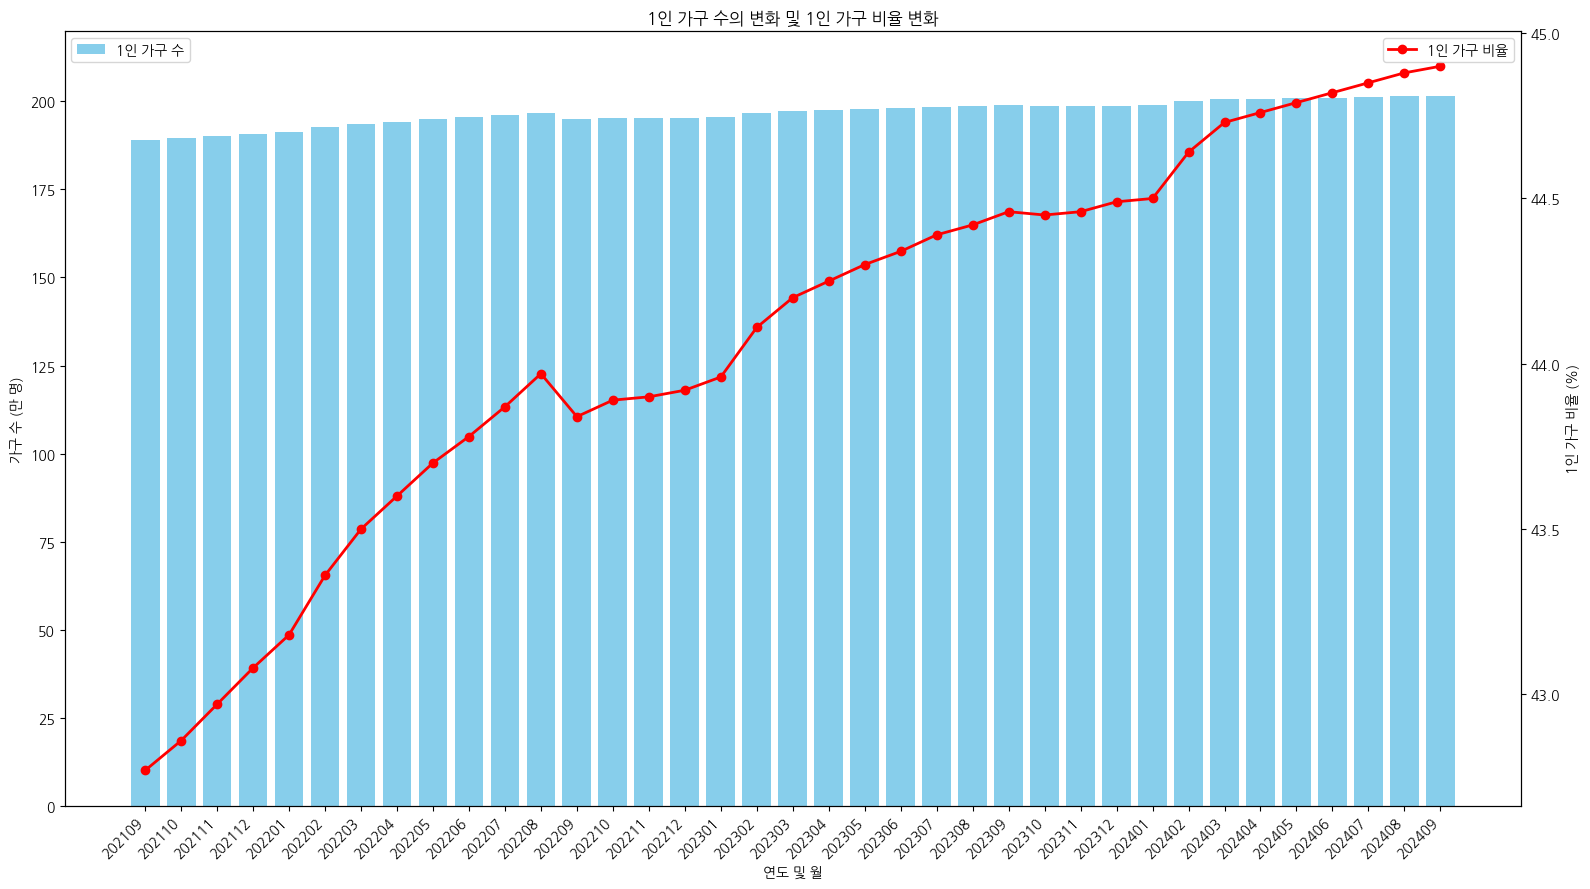

In [63]:
fig, ax1 = plt.subplots(figsize=(16, 9))

x = population_df.index
ax1.bar(x, population_df['1인가구수'], label='1인 가구 수', color='skyblue', align='center')

ax1.set_xlabel('연도 및 월')
ax1.set_ylabel('가구 수 (만 명)')
ax1.set_ylim(0, 220)

ax1.legend(loc='upper left')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(x, population_df['1인가구비율'], label='1인 가구 비율', color='red', marker='o', linewidth=2)
ax2.set_ylabel('1인 가구 비율 (%)')
ax2.legend(loc='upper right')

plt.title('1인 가구 수의 변화 및 1인 가구 비율 변화')
plt.tight_layout()
plt.show()

## 3-2. 1인 가구 데이터 지도 시각화 (2024년 9월 기준)

#### 최신 데이터 불러오기

In [64]:
last_population_csv = population_csv_list[-1]
last_population_df = pd.read_csv(last_population_csv, skiprows=1)
last_population_df.columns = ['자치구', '행정동'] + list(df.columns)[2:]
print(last_population_df.head())

   자치구  행정동   전체세대   1인세대   2인세대   3인세대  4인세대  5인세대 6인세대 7인세대 8인세대 9인세대  \
0  종로구   소계  72341  38117  14676  10122  7030  1793  415  128   33   14   
1  종로구  사직동   4582   2340    950    658   473   117   25   14    2    -   
2  종로구  삼청동   1111    552    250    141   110    38   13    5    2    -   
3  종로구  부암동   4127   1670   1011    737   509   138   43   14    4    -   
4  종로구  평창동   7129   2256   1853   1450  1109   347   76   25    8    2   

  10인세대 이상  
0       13  
1        3  
2        -  
3        1  
4        3  


### 3-2-1. 자치구 별 데이터 시각화

#### 자치구 별 1인가구 소계 데이터 추출

In [65]:
gu_population_df = last_population_df[last_population_df['행정동'] == '소계'][['자치구', '전체세대', '1인세대']].reset_index(drop=True)
print(gu_population_df.info())
print(gu_population_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   자치구     25 non-null     object
 1   전체세대    25 non-null     int64 
 2   1인세대    25 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 732.0+ bytes
None
   자치구    전체세대   1인세대
0  종로구   72341  38117
1   중구   65378  35219
2  용산구  103860  51423
3  성동구  132856  58981
4  광진구  170383  85850


#### 데이터프레임 정제

In [66]:
gu_population_df['1인세대비중'] = round(100 * (gu_population_df['1인세대'] / gu_population_df['전체세대']), 2)

re_gu_population_df = gu_population_df[['자치구', '1인세대비중']].rename(columns={'자치구':'구분'})
print(re_gu_population_df.head())

    구분  1인세대비중
0  종로구   52.69
1   중구   53.87
2  용산구   49.51
3  성동구   44.39
4  광진구   50.39


#### 데이터 시각화

In [67]:
seoul_gu_map = SeoulMap()

with open('../data/geoData/서울_자치구_경계_2017.geojson', encoding='utf-8') as f:
    gu_geodata = json.load(f)


gu_layer = seoul_gu_map.make_layer('서울시 자치구 경계', gu_geodata)
seoul_gu_map.add_layer(gu_layer)

gu_population_layer = seoul_gu_map.make_layer('서울시 자치구별 1인가구')
seoul_gu_map.display_population(gu_population_layer, gu_geodata, re_gu_population_df, ['구분', '1인세대비중'], 'SIG_KOR_NM')
seoul_gu_map.add_layer(gu_population_layer)

seoul_gu_map.show()

### 3-2-2. 행정동 별 데이터 시각화

#### 행정동 별 1인가구 소계 데이터 추출

In [68]:
dong_population_df = last_population_df[last_population_df['행정동'] != '소계'][['자치구', '행정동', '전체세대', '1인세대']].reset_index(drop=True)
print(dong_population_df.info())
print(dong_population_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   자치구     426 non-null    object
 1   행정동     426 non-null    object
 2   전체세대    426 non-null    int64 
 3   1인세대    426 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 13.4+ KB
None
   자치구  행정동  전체세대  1인세대
0  종로구  사직동  4582  2340
1  종로구  삼청동  1111   552
2  종로구  부암동  4127  1670
3  종로구  평창동  7129  2256
4  종로구  무악동  2997   714


#### 데이터프레임 정제

In [69]:
dong_population_df['구분'] = '서울특별시 ' + dong_population_df['자치구'] + ' '+ dong_population_df['행정동']
dong_population_df['1인세대비중'] = round(100 * (dong_population_df['1인세대'] / dong_population_df['전체세대']), 2)
re_dong_population_df = dong_population_df[['구분', '1인세대비중']]
print(re_dong_population_df.head())

              구분  1인세대비중
0  서울특별시 종로구 사직동   51.07
1  서울특별시 종로구 삼청동   49.68
2  서울특별시 종로구 부암동   40.47
3  서울특별시 종로구 평창동   31.65
4  서울특별시 종로구 무악동   23.82


#### 데이터 시각화

In [70]:
seoul_dong_map = SeoulMap()

with open('../data/geoData/서울_행정동_경계_2017.geojson', encoding='utf-8') as f:
    dong_geodata = json.load(f)

dong_layer = seoul_dong_map.make_layer('서울시 행정동 경계', dong_geodata)
seoul_dong_map.add_layer(dong_layer)

dong_population_layer = seoul_dong_map.make_layer('서울시 행정동 1인가구')
seoul_dong_map.display_population(dong_population_layer, dong_geodata, re_dong_population_df, ['구분', '1인세대비중'], 'adm_nm')
seoul_dong_map.add_layer(dong_population_layer)

seoul_dong_map.show()

## 3-3. 또타 스토리지 신설 및 증설 역 제안

### 3-3-1. 1인 가구 및 공실 데이터 지도 시각화

In [71]:
final_map = SeoulMap()
final_map.add_layer(dong_population_layer)
final_map.add_layer(empty_storage_layer)

final_map.show()